# DC2: Generate Postage Stamps for set of RA, Dec coordinates
<br>Owner: **Michael Wood-Vasey** ([@wmwv](https://github.com/LSSTDESC/DC2_Repo/issues/new?body=@wmwv))
<br>Last Verified to Run: **2018-07-19**

This Notebook demonstrates taking a list of RA, Dec positions and generating "postage-stamp" cutout images from the coadded images.  It illustrates using `matplotlib` for simple display and saving of PNGs.  It also introduces using `lsst.afw.display` to use a more DM-product aware visualization to show the detect object footprints and other mask planes.

### Learning Objectives:
After working through and studying this Notebook you should be able to
   1. Generate a postage stamp from a coadd for your chosen RA, Dec in a chosen filter and save as (a) a FITS file and (b) a PNG.
   2. Use afw.display to show a postage stamp along with the mask planes from the coadd image, including overlaying the object footprints.
   3. [Advanced] Instantiate a Butler object for a repo and read an arbitrary coadd image.  This will require reading through functions carefully and testing individual lines.  
   4. [Advanced] Load the PSF model for a coadd and evaluate it at a given RA, Dec.
   5. [Expert] Subtract a scaled PSF model from the location of an object on a coadd.
   6. [Expert] Look up which tract, patch a given RA, Dec falls in.

### Logistics
This is intended to be runnable at NERSC through the https://jupyter-dev.nersc.gov interface from a local git clone of https://github.com/LSSTDESC/DC2_Repo in your NERSC directory.  But you can also run it wherever, with appropriate adjustment of the 'repo' location to point to a place where you have a Butler repo will all of the images. Instructions for setting up the proper python kernel can be found here: https://confluence.slac.stanford.edu/x/1_ubDQ

Based in part on https://github.com/lsst-com/notebooks/blob/master/postage_stamp.ipynb

## Set Up

In [1]:
import os
import numpy as np

from astropy.table import Table

import lsst.daf.persistence as dafPersist
import lsst.afw.geom as afwGeom
import lsst.afw.coord as afwCoord
import lsst.afw.image as afwImage
import lsst.afw.display as afwDisplay

from astropy.visualization import ZScaleInterval

### Interactive backends and NERSC Jupyter vs JupyterLab

If you're running on directly in Jupyter and not JupyterLab
you can instead use below the interactive figure interface (nbAgg)  
`%matplotlib notebook`

We don't do that by default in this Notebook so that it can be run under the NERSC JupyterLab environment, which is what DESC specifically called out in the [instructions for using NERSC](https://confluence.slac.stanford.edu/x/1_ubDQ)
but I recommend that you use the Jupyter interface to get the best out of this Notebook.

If you want to switch from `notebok`<->`inline` you have to restart the Python kernel for this Jupyter Notebook.  I recommend using the "Kernel->Restart & Clear Output" menu option above.

The distinction between Jupyter and JupyterLab is confusing, so I'll repeat here with the specific examples:
1. This is my Jupyter URL and specific URL of this Notebook URL at NERSC:  
https://jupyter-dev.nersc.gov/user/wmwv/  
https://jupyter-dev.nersc.gov/user/wmwv/notebooks/global/homes/w/wmwv/DC2_Repo/Notebooks/DC2_Postage_Stamps.ipynb

2. This is my JupyterLab URL and specific URL of this Notebook at NERSC:  
https://jupyter-dev.nersc.gov/user/wmwv/lab  
https://jupyter-dev.nersc.gov/user/wmwv/lab/tree/global/homes/w/wmwv/DC2_Repo/Notebooks/DC2_Postage_Stamps.ipynb

The interactive 'notebook' (nbAgg) backend will work with #1 but will not work with #2.

In [2]:
# Set plotting to 'inline' figures
# If you're running on directly in Jupyter and not JupyterLab
# you can instead use the interactive figure interface (nbAgg).
%matplotlib inline
# %matplotlib notebook

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (6, 6)
zscale = ZScaleInterval()

## How To Make a Cutout Image

The DM butler's `get` method enables postage stamp making, via a bounding box keyword argument. The functions below show how to make this bounding box, and apply it.

In [3]:
def cutout_coadd_ra_dec(butler, ra, dec, filter='r', datasetType='deepCoadd', **kwargs):
    """
    Produce a cutout from coadd from the given butler at the given RA, Dec in decimal degrees.
    
    Notes
    -----
    Trivial wrapper around 'cutout_coadd_spherepoint'
    
    Parameters
    ----------
    butler: lsst.daf.persistence.Butler
        Servant providing access to a data repository
    ra: float
        Right ascension of the center of the cutout, degrees
    dec: float
        Declination of the center of the cutout, degrees
    filter: string
        Filter of the image to load
        
    Returns
    -------
    MaskedImage
    """
    radec = afwGeom.SpherePoint(ra, dec, afwGeom.degrees)
    return cutout_coadd_spherepoint(butler, radec, filter=filter, datasetType=datasetType)
    

def cutout_coadd_spherepoint(butler, radec, filter='r', datasetType='deepCoadd',
                                  skymap=None, cutoutSideLength=51, **kwargs):
    """
    Produce a cutout from a coadd at the given afw SpherePoint radec position.
    
    Parameters
    ----------
    butler: lsst.daf.persistence.Butler
        Servant providing access to a data repository
    radec: lsst.afw.geom.SpherePoint 
        Coordinates of the center of the cutout.
    filter: string 
        Filter of the image to load
    datasetType: string ['deepCoadd']  
        Which type of coadd to load.  Doesn't support 'calexp'
    skymap: lsst.afw.skyMap.SkyMap [optional] 
        Pass in to avoid the Butler read.  Useful if you have lots of them.
    cutoutSideLength: float [optional] 
        Side of the cutout region in pixels.
    
    Returns
    -------
    MaskedImage
    """
    cutoutSize = afwGeom.ExtentI(cutoutSideLength, cutoutSideLength)

    if skymap is None:
        skymap = butler.get("%s_skyMap" % datasetType)
    
    # Look up the tract, patch for the RA, Dec
    tractInfo = skymap.findTract(radec)
    patchInfo = tractInfo.findPatch(radec)
    xy = afwGeom.PointI(tractInfo.getWcs().skyToPixel(radec))
    bbox = afwGeom.BoxI(xy - cutoutSize//2, cutoutSize)

    coaddId = {'tract': tractInfo.getId(), 'patch': "%d,%d" % patchInfo.getIndex(), 'filter': filter}
    
    cutout_image = butler.get(datasetType+'_sub', bbox=bbox, immediate=True, dataId=coaddId)
    
    return cutout_image

In [4]:
def make_cutout_image(butler, ra, dec, filter='r', vmin=None, vmax=None, label=None,
                      show=True, saveplot=False, savefits=False,
                      datasetType='deepCoadd'):
    """
    Generate and optionally display and save a postage stamp for a given RA, Dec.
    
    Parameters
    ----------
    butler: lsst.daf.persistence.Butler
        Servant providing access to a data repository
    ra: float
        Right ascension of the center of the cutout, degrees
    dec: float
        Declination of the center of the cutout, degrees
    filter: string 
        Filter of the image to load
    Returns
    -------
    MaskedImage

    Notes
    -----
    Uses matplotlib to generate stamps.  Saves FITS file if requested.
    """

    cutout_image = cutout_coadd_ra_dec(butler, ra, dec, filter=filter, datasetType='deepCoadd')
    if savefits:
        if isinstance(savefits, str):
            filename = savefits
        else:
            filename = 'postage-stamp.fits'
        cutout_image.writeFits(filename)
    
    radec = afwGeom.SpherePoint(ra, dec, afwGeom.degrees)
    xy = cutout_image.getWcs().skyToPixel(radec)
    
    if vmin is None or vmax is None:
        vmin, vmax = zscale.get_limits(cutout_image.image.array)

    plt.imshow(cutout_image.image.array, vmin=vmin, vmax=vmax, cmap='binary_r', origin='lower')
    plt.colorbar()
    plt.scatter(xy.getX() - cutout_image.getX0(), xy.getY() - cutout_image.getY0(),
                color='none', edgecolor='red', marker='o', s=200)
    if label is not None:
        plt.title(label)
    if saveplot:
        if isinstance(saveplot, str):
            filename = saveplot
        else:
            filename = 'postage-stamp.png'
        plt.savefig(filename)
    if show:
        plt.show()

    return cutout_image

## Making Some Postage Stamps

We'll use a list of 20 targets, pre-selected and checked into the Notebooks folder, and have the butler make postage stamps from the Run 1.1 coadd images.

In [5]:
repo = '/global/projecta/projectdirs/lsst/global/in2p3/Run1.1/output'
butler = dafPersist.Butler(repo)

In [6]:
filter = 'r'
coord_file = 'id_ra_dec_mid_mag_%s.txt' % filter
id_ra_dec = Table.read(coord_file, format='ascii')

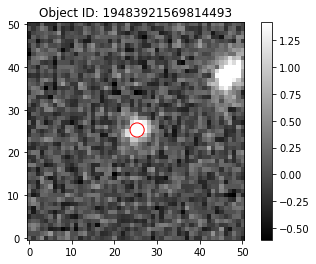

In [7]:
# Plot just one
i = 3
first = id_ra_dec[i]
ra, dec = first['RA'], first['DEC']
frame = 0
plt.figure(frame)
cutout = make_cutout_image(butler, ra, dec, filter=filter, label="Object ID: %d" % id_ra_dec[i]['ID'])

If we use `notebook` as the backend, we can interact with the figure and read off pixel coordinates and counts.

We can loop over this to create postage-stamps for each entry in our catalog.  To keep the Notebooks folder tidy, we'll make and use a subfolder.

We use `show=False` because we don't necessarily want to display each of the 20 figures.  But even with `show=False` we will get a figure displayed in interactive `%matplotlib notebook` mode because under that backend, one is always displaying the figure without waiting for a `plt.show` command.

In [8]:
subfolder = 'Stamps'
if not os.path.exists(subfolder):
    os.mkdir(subfolder)

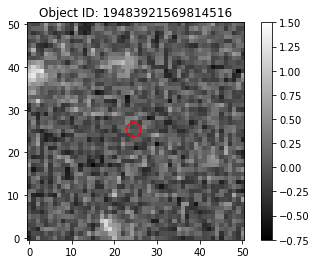

In [9]:
frame = 1
show = False
datasetType = 'deepCoadd'
vmin, vmax = -0.75, +1.5  # Fix the vmin, vmax to make it easier to compare across postage stamps.

for objectId, ra, dec in id_ra_dec:
    plt.figure(frame)
    plt.clf()
    basename = "Stamps/%s_%s_%s" % (datasetType, objectId, filter)
    saveplot = "%s.png" % basename
    savefits = "%s.fits" % basename
    make_cutout_image(butler, ra, dec, filter=filter, vmin=vmin, vmax=vmax,
                      datasetType=datasetType,
                      label="Object ID: %d" % objectId,
                      show=show, saveplot=saveplot, savefits=savefits)

## AFW Display

But there's additional information available in the Exposure object that we can access using LSST DM tools that are aware of these.  Specifically, we'll use `lsst.afw.display` to expose the mask planes in a cutout image.

In [10]:
def display_cutout_image(butler, ra, dec, vmin=None, vmax=None, label=None,
                      frame=None, display=None, backend='matplotlib',
                      show=True, saveplot=False, savefits=False,
                      old_matplotlib = False,
                      datasetType='deepCoadd'):
    """
    Display a postage stamp for a given RA, Dec using LSST lsst.afw.display.
    
    Parameters
    ----------
    backend: string
        Backend can be anything that lsst.afw.display and your configuration supports: 
        e.g. matplotlib, ds9, ginga, firefly.
    
    Returns
    -------
    MaskedImage
    
    Notes
    -----
    Parameters are the same as for make_cutout_image, except for the backend.
    You definitely have the matplotlib backend.
    ds9, ginga, and firefly can be set up but are non-trivial on the scale of a simple Notebook.
    """
    cutout_image = cutout_coadd_ra_dec(butler, ra, dec, filter='r', datasetType='deepCoadd')
    if savefits:
        if isinstance(savefits, str):
            filename = savefits
        else:
            filename = 'postage-stamp.fits'
        cutout_image.writeFits(filename)
    
    if display is None:
        display = afwDisplay.Display(frame=frame, backend=backend)

    radec = afwGeom.SpherePoint(ra, dec, afwGeom.degrees)
    xy = cutout_image.getWcs().skyToPixel(radec)
    
    display.mtv(cutout_image)
    display.scale("asinh", "zscale")
    display.dot('o', xy.getX(), xy.getY(), ctype='red')
    display.show_colorbar()
    
    return cutout_image

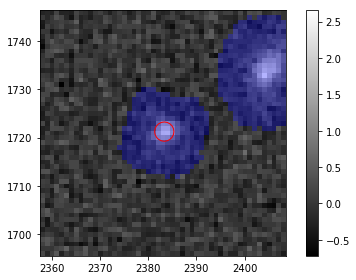

In [11]:
# Display just one
i = 3
first = id_ra_dec[i]
ra, dec = first['RA'], first['DEC']

# We start specifying figure numbers here and below to explicitly control which figure we're plotting to
# If we use the interactive `%matplotlib notebook` (nbAgg),
# then figures stay active even when you exit the cell.
# It can then be confusing to figure out which figure is active.
# (matplotlib.pyplot doesn't call these 'frame's, but afwDisplay does)
frame = 2
plt.figure(frame)
cutout = display_cutout_image(butler, ra, dec, frame=frame,
                              label="Object ID: %d" % id_ra_dec[i]['ID'])

# After we have the displayed image we can interact with it a bit through matplotlib
plt.savefig('afwDisplay.png')

Here when we browse around we get both x,y coordinates (RA, Dec) = $(\alpha, \delta)$ the pixel counts as well as the list of named mask bits that are set for the pixels.

## Using mask planes

Along with the pixels, the coadd image also has a set of associated "mask" planes. "Mask" means has an identified property -- it doesn't necessarily mean "bad".  In particular, the "DETECTED" mask plane means the measurement identified an object here.  "Plane" here refers to a specific bit in the mask.

Specifically, the blue overlays above are called the "footprints" for the observations.  These are the pixels identified by the pipeline as "belonging" to the object: pixels where the object contributes detectable number of photons above the sky background.

The colors are configurable, but the default values are:

In [12]:
frame = 1
plt.figure(frame)
display = afwDisplay.Display(frame=frame, backend='matplotlib')
for maskName, maskBit in cutout.mask.getMaskPlaneDict().items():
    print('{}: {}'.format(maskName, display.getMaskPlaneColor(maskName)))

BAD: red
CLIPPED: None
CR: magenta
DETECTED: blue
DETECTED_NEGATIVE: cyan
EDGE: yellow
INEXACT_PSF: None
INTRP: green
NO_DATA: orange
REJECTED: None
SAT: green
SENSOR_EDGE: None
SUSPECT: yellow


### Comparing `plt.imshow` and `afwDisplay`:
* X,Y origin  
    Note that `afwDisplay` displays images with the lower-left as the origin, which is the x,y convention that most  astronomers are using to thinking in.  This is opposite to the default vertical orientation in `matplotlib.pyplot.imshow`, thus we passed `origin='lower'` in our call above to `imshow`. `afwDisplay` also provides the original pixel coordinates of the tract+patch coadd image, which is potentially useful.
* Colormap  
    This is an arbitrary choice, but `afwDisplay` displays pixels with large values in lighter shades. We match this with the `binary_r` colormap in `matplotlib`.
* Colorbar 
  We have added the colorbar explicitly with a call to `plt.colorbar`.
* Saving output
  Again, we've used the `matplotlib` interface to save the resulting figure to a PNG.  This is not presently possible directly from the afwDisplay object.

Take a look at https://pipelines.lsst.io/v/DM-11077/getting-started/display.html for a few more details on afwDisplay. You can also look at [the source code](https://github.com/lsst/display_matplotlib/blob/master/python/lsst/display/matplotlib/matplotlib.py) for the matplotlib backend to afwDisplay.

## Using the PSF Model

The cutout image object retains full information from the image, including the PSF model.

The PSF model is accessible as a function object that can be evaluated a specific locations.

In addition, the coadd catalog saves the xx, xy, yy moments of the PSF model at the location of photometered objects.

In [13]:
# We still have our cutout image object from above
psf = cutout.getPsf()

In [14]:
print(psf)

The repetition in the object name is a consequence of the pybind11 mapping.  It's really a `lsst.meas.algorithms.coaddPsf.CoaddPsf` object.  The C++ documentation unfortunately doesn't come through nicely through the wrapping to Python:

In [15]:
help(psf)

Help on CoaddPsf in module lsst.meas.algorithms.coaddPsf.coaddPsf object:

class CoaddPsf(PersistableFacadeCoaddPsf, lsst.meas.algorithms.imagePsf.ImagePsf)
 |  Method resolution order:
 |      CoaddPsf
 |      PersistableFacadeCoaddPsf
 |      lsst.meas.algorithms.imagePsf.ImagePsf
 |      lsst.meas.algorithms.imagePsf.PersistableFacadeImagePsf
 |      lsst.afw.detection._psf.Psf
 |      lsst.daf.base.persistable.Persistable
 |      lsst.daf.base.citizen.citizen.Citizen
 |      pybind11_builtins.pybind11_object_56
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(...) from builtins.PyCapsule
 |      __init__(*args, **kwargs)
 |      Overloaded function.
 |      
 |      1. __init__(self: lsst.meas.algorithms.coaddPsf.coaddPsf.CoaddPsf, catalog: lsst.afw.table.exposure.exposure.ExposureCatalog, coaddWcs: lsst.afw.geom.skyWcs.skyWcs.SkyWcs, weightFieldName: str='weight', warpingKernelName: str='lanczos3', cacheSize: int=10000) -> None
 |      
 |      2. __init__(

We can look up the documentation in the LSST DM Stack Doxygen pages.  If we assume (correctly for these purposes) that a CoaddPsf is just like a regular PSF, then we can look here:
http://doxygen.lsst.codes/stack/doxygen/x_masterDoxyDoc/classlsst_1_1afw_1_1detection_1_1_psf.html

where we will see that there are several relevant functions:
`computeImage`: Return an Image of the PSF, in a form that can be compared directly with star images.
`computeKernelImage`:  Return an Image of the PSF, in a form suitable for convolution.
`computeShape`: Compute the ellipse corresponding to the second moments of the Psf.

and then some interesting things you might not have expected to even be available:
`getAverageColor`: Return the average Color of the stars used to construct the Psf.
`getAveragePosition`: Return the average position of the stars used to construct the Psf. 

Unfortunately, the documentation is hard to read from a Python perspective.  What kind of arguments does the following function actually want and how do I create those objects?

computeImage(...) from builtins.PyCapsule
        computeImage(self: lsst.afw.detection._psf.Psf, position: lsst.afw.geom.coordinates.coordinates.Point2D=Point2D(nan, nan), color: lsst.afw.image.color.Color=<lsst.afw.image.color.Color object at 0x2b8f57b38928>, owner: lsst.afw.detection._psf.ImageOwnerEnum=ImageOwnerEnum.COPY) -> lsst.afw.image.image.image.ImageD)

Examples are easiest:

In [16]:
# Let's use the same first row to get an RA, Dec and translate that to an x, y on the image plane.
first = id_ra_dec[i]
ra, dec = first['RA'], first['DEC']
radec = afwGeom.SpherePoint(ra, dec, afwGeom.degrees)
xy = cutout.getWcs().skyToPixel(radec)  # returns a Point2D

kernel_image = psf.computeImage(xy)

The object we get back is an `lsst.afw.image.image.ImageD` -- An `Image` in double precision.

Let's display the kernel image we made:

In [17]:
help(kernel_image)

Help on ImageD in module lsst.afw.image.image.image object:

class ImageD(ImageBaseD)
 |  Method resolution order:
 |      ImageD
 |      ImageBaseD
 |      lsst.daf.base.persistable.Persistable
 |      lsst.daf.base.citizen.citizen.Citizen
 |      pybind11_builtins.pybind11_object_56
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  Factory(self, *args, **kwargs)
 |      Return an object of this type
 |  
 |  __add__(...) from builtins.PyCapsule
 |      __add__(self: lsst.afw.image.image.image.ImageD, arg0: lsst::afw::image::ImageSlice<double>) -> lsst.afw.image.image.image.ImageD
 |  
 |  __float__(self)
 |      Convert a 1x1 image to a floating scalar
 |  
 |  __getitem__(self, imageSlice)
 |  
 |  __iadd__(...) from builtins.PyCapsule
 |      __iadd__(*args, **kwargs)
 |      Overloaded function.
 |      
 |      1. __iadd__(self: lsst.afw.image.image.image.ImageD, arg0: float) -> lsst.afw.image.image.image.ImageD
 |      
 |      2. __iadd__(self: lsst.afw.image.imag

For comparison, the postage stamp is a full `lsst.afw.image.exposure.ExposureF`.  An `Exposure` contains a `MaskedImage` (an image, a mask, and variance plane), along with an optional SkyWCS.
http://doxygen.lsst.codes/stack/doxygen/x_masterDoxyDoc/classlsst_1_1afw_1_1image_1_1_exposure.html#details

An `Exposure` can also generate `subExposures`, which are `Exposure`s of a subset of the pixels.  Our postage stamp cutout is thus an `Exposure`.  The additional information is what allowed `afwDisplay` to show the image with the original pixel coordinates.

If you read a `raw`, `calexp`, or `deepCoadd` or similar image product through the Butler, you will get an `Exposure`.

In [18]:
help(cutout)

Help on ExposureF in module lsst.afw.image.exposure.exposure object:

class ExposureF(lsst.daf.base.persistable.Persistable)
 |  Method resolution order:
 |      ExposureF
 |      lsst.daf.base.persistable.Persistable
 |      pybind11_builtins.pybind11_object_56
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __getitem__(self, imageSlice)
 |  
 |  __init__(...) from builtins.PyCapsule
 |      __init__(*args, **kwargs)
 |      Overloaded function.
 |      
 |      1. __init__(self: lsst.afw.image.exposure.exposure.ExposureF, width: int, height: int, wcs: lsst.afw.geom.skyWcs.skyWcs.SkyWcs=None) -> None
 |      
 |      2. __init__(self: lsst.afw.image.exposure.exposure.ExposureF, dimensions: lsst.geom.coordinates.coordinates.Extent2I=Extent2I(0, 0), wcs: lsst.afw.geom.skyWcs.skyWcs.SkyWcs=None) -> None
 |      
 |      3. __init__(self: lsst.afw.image.exposure.exposure.ExposureF, bbox: lsst.geom.box.Box2I, wcs: lsst.afw.geom.skyWcs.skyWcs.SkyWcs=None) -> None
 |      
 |

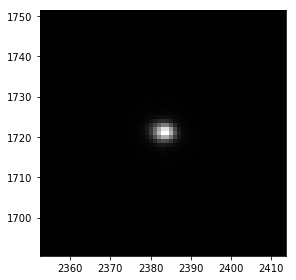

In [19]:
frame = 2
plt.figure(frame)
display = afwDisplay.Display(frame=frame, backend='matplotlib')
display.scale("linear", "minmax")
display.mtv(kernel_image)

Above we see an image of the PSF centered at the x, y position corresponding to the RA, Dec position of the object.  This is a convenient representation to use to subtract.

Note that while the cutout was 51x51 pixels (the default `cutoutSideLength` in `cutout_coadd_spherepoint` above), the PSF is 61x61 pixels.  That's the default size of specifying the full PSF.

In [20]:
print("Cutout shape: ", np.shape(cutout.image.array))
print("PSF shape: ", np.shape(kernel_image.array))

Cutout shape:  (51, 51)
PSF shape:  (61, 61)


In [21]:
print(np.sum(kernel_image.array))  # Kernel is normalized to total sum of 1 over the size of the PSF.

1.0


We next scale our PSF model to the detected object in the coadd and illustrate using a 1D slice.  We have to account for the different sizes of the PSF model and the cutout, including the finite fraction of PSF flux included in the smaller cutout  The scaling is the the total sum along the slice in this overly simple model.

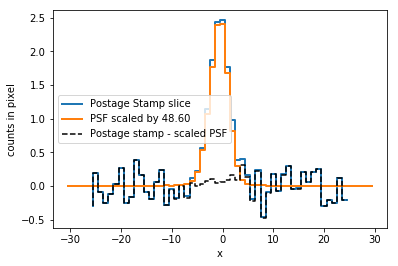

In [22]:
frame = 3
plt.figure(frame)
cutout_nx, cutout_ny = np.shape(cutout.image.array)
kernel_nx, kernel_ny = np.shape(kernel_image.array)

cutout_slice = cutout.image.array[cutout_nx//2, :]
kernel_slice = kernel_image.array[kernel_nx//2, :]

# Normalize PSF sum to cutout sum in this slice
scaling = np.sum(cutout_slice)/np.sum(kernel_slice)

plt.step(np.arange(cutout_nx) - cutout_nx/2, cutout_slice,
         label='Postage Stamp slice',
         linewidth=2)
plt.step(np.arange(kernel_nx) - kernel_nx/2, scaling * kernel_slice,
         label='PSF scaled by %.2f' % scaling,
         linewidth=2)

# Assume that the PSF kernel size is *larger* than the cutout size.
offset_nx = kernel_nx - cutout_nx
offset_ny = kernel_ny - cutout_ny

plt.step(np.arange(cutout_nx) - cutout_nx/2,
         cutout_slice - (scaling * kernel_slice[offset_nx//2:-offset_nx//2]),
         label='Postage stamp - scaled PSF',
         linestyle='--', color='black')
plt.xlabel('x')
plt.ylabel('counts in pixel')
plt.legend()
plt.show()

Subtract a scaled version of the PSF from the image array.
Note that we have to select out just the section of the PSF that's within the cutout.

In [23]:
cutout_minus_psf = cutout.image.array - \
    scaling * kernel_image.array[offset_nx//2:-offset_nx//2,
                                 offset_ny//2:-offset_ny//2]

To create an `Exposure` with the pixel values of subtracting the PSF model we create a copy of the postage stamp and set the image data array to the residual value we just calculated above.
We keep the WCS, the pixel mapping of this subExposure, and the mask and variance plane.

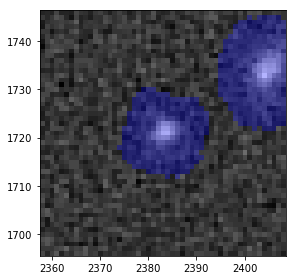

In [24]:
residual = cutout.clone()
residual.setImage(afwImage.ImageF(afwImage.ImageF(cutout_minus_psf.astype(np.float32))))

frame = 4
plt.figure(frame)
display = afwDisplay.Display(frame=frame,backend='matplotlib')
display.scale("linear", "minmax")
display.mtv(cutout)

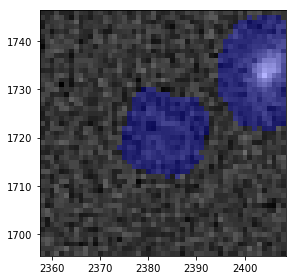

In [25]:
frame = 5
fig = plt.figure(frame)

display = afwDisplay.Display(frame=frame, backend='matplotlib')

display.scale("linear", "minmax")
display.mtv(residual)

And the source is gone.  The actual fitting for the PSF flux is a bit more complicated, but the above demonstrates the basic process of evaluating a PSF at a location in the image and creating a new `Image` or `Exposure` object with a PSF model subtracted out.